In [46]:
import argparse, os, time
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [63]:
year = 22
donors_csv = f"./output/donors{year}_pred_lastname.csv"

In [64]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,"HOME, 30119 SETTLE",30119 settle home,[24T Contribution],NaN,,NOT EMPLOYED,NOT EMPLOYED,1.649385e+09,115116,1.432803e+04,25.0,home,not
1,U00000003641,"SOROS, GEORGE",george soros,Soros Fund Management,NaN,M,EXECUTIVE,SOROS FUND MANAGEMENT,1.800173e+08,204,8.824376e+05,2900.0,soros,not
2,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M,CEO/OWNER,ULINE,8.422153e+07,369,2.282426e+05,2900.0,uihlein,not
3,U00000036551,"GRIFFIN, KENNETH C",kenneth c griffin,Citadel LLC,NaN,M,CEO,CITADEL LLC,7.437550e+07,317,2.346230e+05,2900.0,griffin,not
4,U00000042451,"YASS, JEFF",jeff yass,Susquehanna International Group,NaN,M,MANAGING DIRECTOR,SIG,5.632450e+07,49,1.149480e+06,5800.0,yass,not
5,U0000004705,"BANKMAN-FRIED, SAMUEL",samuel bankman-fried,FTX.US,NaN,M,CEO,FTX US,4.204488e+07,338,1.243931e+05,5000.0,bankman-fried,not
6,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investor,NaN,M,INVESTOR,SELF-EMPLOYED,4.174640e+07,31,1.346658e+06,2900.0,mellon,not
7,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,Bloomberg Lp,NaN,M,FOUNDER,BLOOMBERG INC.,4.133051e+07,39,1.059757e+06,200000.0,bloomberg,not
8,U0000003235,"EYCHANER, FRED",fred eychaner,Newsweb Corp,NaN,M,OWNER,NEWSWEB CORP,3.782750e+07,234,1.616560e+05,10000.0,eychaner,not
9,U00000003611,"SCHWARZMAN, STEPHEN",stephen schwarzman,Blackstone Group,NaN,M,CHAIRMAN CEO,BLACKSTONE,3.754490e+07,281,1.336117e+05,2900.0,schwarzman,not


In [65]:
len(donors)

2761018

In [66]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

51.50971586969463


,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,"HOME, 30119 SETTLE",30119 settle home,[24T Contribution],NaN,,NOT EMPLOYED,NOT EMPLOYED,1.649385e+09,115116,1.432803e+04,25.0,home,not
1,U00000003641,"SOROS, GEORGE",george soros,Soros Fund Management,NaN,M,EXECUTIVE,SOROS FUND MANAGEMENT,1.800173e+08,204,8.824376e+05,2900.0,soros,not
2,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M,CEO/OWNER,ULINE,8.422153e+07,369,2.282426e+05,2900.0,uihlein,not
3,U00000036551,"GRIFFIN, KENNETH C",kenneth c griffin,Citadel LLC,NaN,M,CEO,CITADEL LLC,7.437550e+07,317,2.346230e+05,2900.0,griffin,not
4,U00000042451,"YASS, JEFF",jeff yass,Susquehanna International Group,NaN,M,MANAGING DIRECTOR,SIG,5.632450e+07,49,1.149480e+06,5800.0,yass,not
5,U0000004705,"BANKMAN-FRIED, SAMUEL",samuel bankman-fried,FTX.US,NaN,M,CEO,FTX US,4.204488e+07,338,1.243931e+05,5000.0,bankman-fried,not
6,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investor,NaN,M,INVESTOR,SELF-EMPLOYED,4.174640e+07,31,1.346658e+06,2900.0,mellon,not
7,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,Bloomberg Lp,NaN,M,FOUNDER,BLOOMBERG INC.,4.133051e+07,39,1.059757e+06,200000.0,bloomberg,not
8,U0000003235,"EYCHANER, FRED",fred eychaner,Newsweb Corp,NaN,M,OWNER,NEWSWEB CORP,3.782750e+07,234,1.616560e+05,10000.0,eychaner,not
9,U00000003611,"SCHWARZMAN, STEPHEN",stephen schwarzman,Blackstone Group,NaN,M,CHAIRMAN CEO,BLACKSTONE,3.754490e+07,281,1.336117e+05,2900.0,schwarzman,not


In [67]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
37,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,M,DIRECTOR OF ENGINEERING,FTX,8476000.0,148,57270.270270,2900.0,singh,ind
123,U00000040581,"ANWAR, S, JAVAID",javaid anwar,Midland Energy,NaN,M,PRESIDENT/CEO,MIDLAND ENERGY INC.,3232392.0,287,11262.689895,2900.0,anwar,ind
197,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,M,VENTURE CAPITALIST,"KHOSLA VENTURES, LLC",2084900.0,30,69496.666667,5000.0,khosla,ind
260,U00000045811,"MANOCHERIAN, JED",jed manocherian,[24T Contribution],NaN,M,REAL ESTATE,SELF,1557000.0,236,6597.457627,2900.0,manocherian,ind
279,U00000047321,"KIANI, JOE",joe kiani,Masimo Corp,NaN,M,CEO,MASIMO,1460800.0,52,28092.307692,2900.0,kiani,ind
385,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,M,PHYSICIAN,PRIME HEALTHCARE SERVICES,1088749.0,78,13958.320513,3205.0,reddy,ind
401,m0001124160,"PALIHAPITIYA, CHAMATH",chamath palihapitiya,Social Capital LP,NaN,M,FOUNDER,SOCIAL CAPITAL,1055600.0,15,70373.333333,2900.0,palihapitiya,ind
542,p00042647281,"SRIVASTAVA, GAURAV",gaurav srivastava,Dudek,NaN,M,CHAIRMAN,UNITY RESOURCE GROUP,854000.0,15,56933.333333,12900.0,srivastava,ind
569,i3003502315,"MOHIT, FARHAD",farhad mohit,Investor,NaN,M,INVESTOR,SELF-EMPLOYED,825000.0,13,63461.538462,50000.0,mohit,ind
657,c01704896561,"QAZI, MOHAMMAD A",mohammad a qazi,Ciena Healthcare Management,NaN,M,CEO,CIENA HEALTHCARE,740555.0,114,6496.096491,2900.0,qazi,ind


In [68]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

10603275902.0
88612878.0
0.8357122724995373 % of donated amount is from diaspora


In [69]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

2761018
17316
0.6271599822963849 % of donors are from diaspora


In [70]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

4.0
2.0


In [71]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

500.0
889.5


In [87]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3840.3501541822616
5117.398821898822


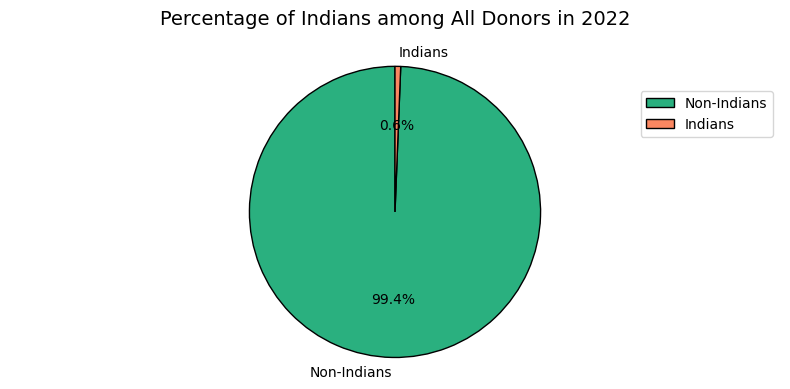

In [72]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

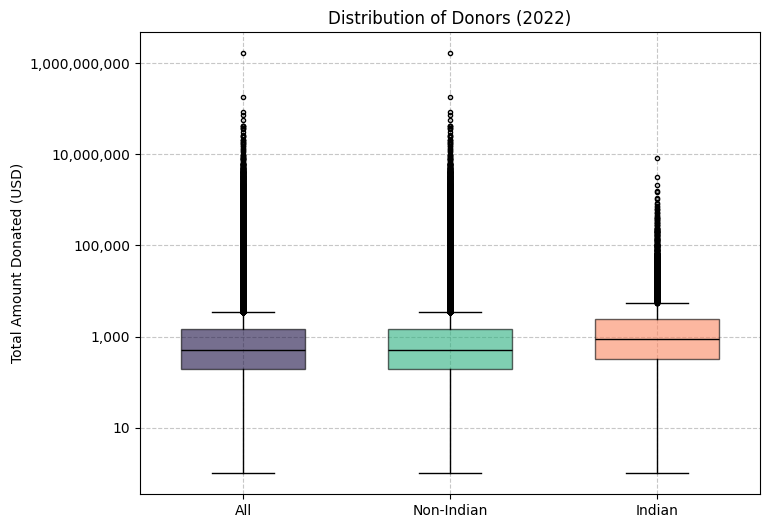

In [73]:
amounts_all = donors['total_donated']
amounts_non_indian = donors[donors['ethnic'] == "not"]['total_donated']
amounts_indian = donors[donors['ethnic'] == "ind"]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], 
                   tick_labels=["All", "Non-Indian", "Indian"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title(f"Distribution of Donors (20{year})")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

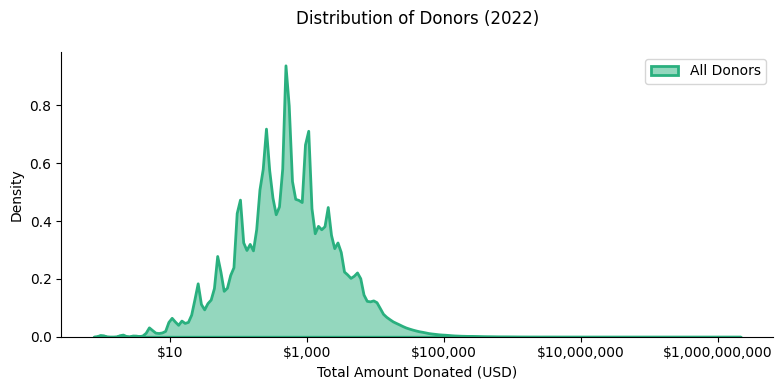

In [74]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
]['total_donated'],
            label='All Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

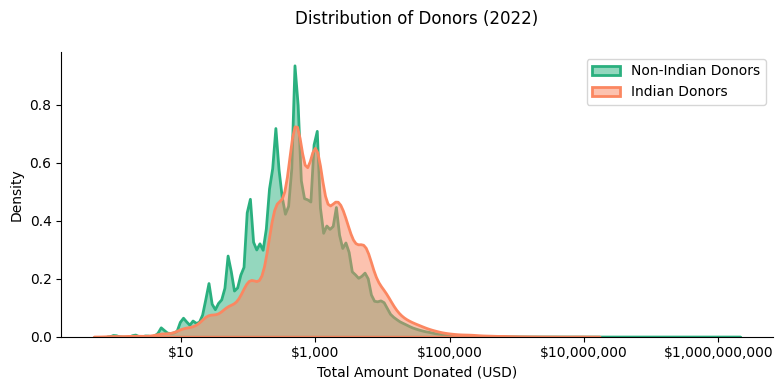

In [75]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "not"]['total_donated'],
            label='Non-Indian Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "ind"]['total_donated'],
            label='Indian Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [76]:
len(donors[donors["ethnic"] == "ind"])

17316

In [77]:
donors.columns

Index(['contrib_id', 'name', 'name_new', 'orgname', 'ultorg', 'gender',
       'occupation', 'employer', 'total_donated', 'donation_count',
       'avg_donation', 'med_donation', 'lastname', 'ethnic'],
      dtype='object')

In [79]:
donors['orgname'].value_counts()[:15]

orgname
Retired                                   553773
[24T Contribution]                        427092
Unemployed                                107205
Save America JFC                           65496
Team Herschel                              36779
National Republican Senatorial Cmte        28207
National Republican Congressional Cmte     25695
Republican National Cmte                   23460
Attorney                                   13075
Team Scalise                               10512
Physician                                   8044
Homemaker                                   6740
Marco Rubio for Senate                      6694
Self-Employed                               6548
Kevin McCarthy for Congress                 6502
Name: count, dtype: int64

In [ ]:
donors['occupation'].value_counts()[15:30]

occupation
EXECUTIVE                14097
REAL ESTATE BROKER       13859
SELF-EMPLOYED            13147
LAWYER                   12723
DIRECTOR                 12163
FARMER                   11896
REAL ESTATE              10465
FACTORY WORKER           10377
PARTNER                  10230
REALTOR                   9833
BUSINESS OWNER            8371
SOFTWARE ENGINEER         7840
VICE PRESIDENT            7323
ACCOUNTANT                6297
INFORMATION REQUESTED     6215
Name: count, dtype: int64

In [86]:
donors['employer'].value_counts()[:15]

employer
RETIRED                            608362
NOT EMPLOYED                       379851
SELF-EMPLOYED                       83774
SELF                                83560
NONE                                67445
SELF EMPLOYED                       48635
HOMEMAKER                           10520
USPS                                 6439
INFORMATION REQUESTED                6069
FORD MOTOR COMPANY                   5192
FEDERAL AVIATION ADMINISTRATION      4910
LDC AND AFFILIATED LOCALS            4047
ENTREPRENEUR                         3401
LOCKHEED MARTIN                      3212
GENERAL MOTORS COMPANY               3195
Name: count, dtype: int64

In [83]:
len(donors[donors["occupation"] == "ENGINEER"])/len(donors)*100

0.8422255849110726